Cerco di capire sta cosa dei J che vengono imparati subito ma con slope sbagliata, e poi si aggiustano

In [56]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm

File names for data

In [2]:
experiment_id = "Dop8V2430"
round_ids = ["ARN", "R01", "R02N"]

In [ ]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)

In [3]:
dtype = torch.float32
device = utils.best_device()

In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [6]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [8]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

In [17]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [18]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [19]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [20]:
checkpoint_filename = experiment_id
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, filename=checkpoint_filename),
             callback.ParamsCallback(save_every=100)]

In [61]:
n_sweeps = 10
lr = 0.01
max_epochs = 2 * 10**3
checkpoint_every = 10**3
checkpoint_filename = experiment_id

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights,
               checkpoint_every=checkpoint_every, checkpoint_filename=checkpoint_filename)

 0.00%[                                                                                        ] Epoch: 0/2000…

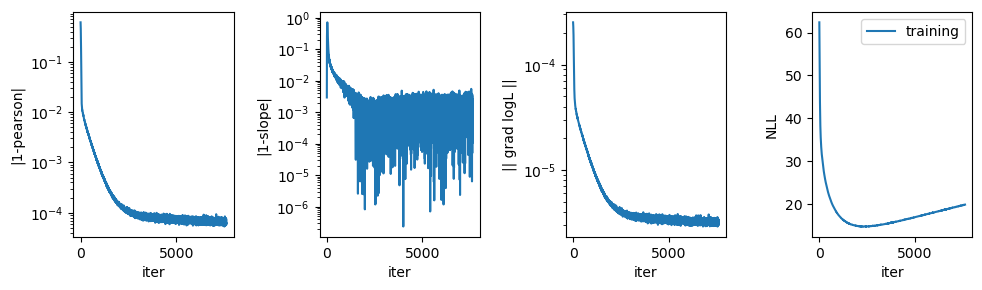

In [62]:
fig, axes = callbacks[0].plot();

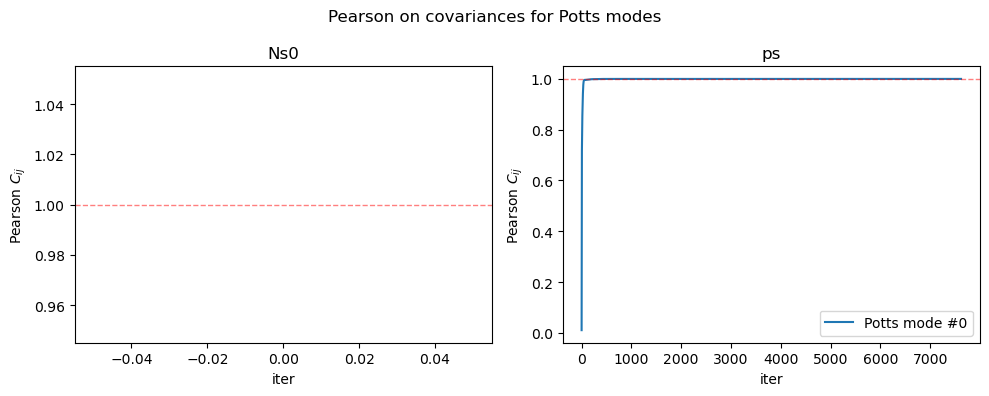

In [63]:
callbacks[1].plot();

<IPython.core.display.Latex object>

Multi-round


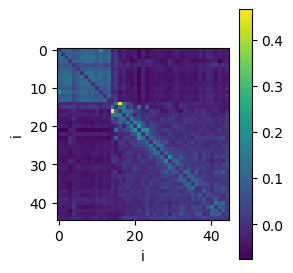

In [64]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

In [65]:
torch.save(model, f'saved/{experiment_id}.pt')

In [66]:
cps = training.load_checkpoints(checkpoint_filename)
nlls = []

for n in range(len(cps)):
    cp = cps[n]
    model_ = cp['model']
    log_weights_ = cp['log_weights'] 
    batches = [next(iter(dl)) for dl in data_loaders]
    nll = - training.estimate_log_likelihood(model_, batches, total_reads, log_weights_)
    nlls.append(nll)

Loaded 15 files.


In [67]:
Fs = []
Js = []
hs = []
for n in range(len(cps)):
    cp = cps[n]
    model_ = cp['model']
    potts_zerosum = model_.selection.modes[0].set_zerosum_gauge()
    J = potts_zerosum.J.detach()
    h = potts_zerosum.h.detach()
    F = selex_dca.get_contact_map(J)
    Fs.append(F)
    Js.append(J)
    hs.append(h)

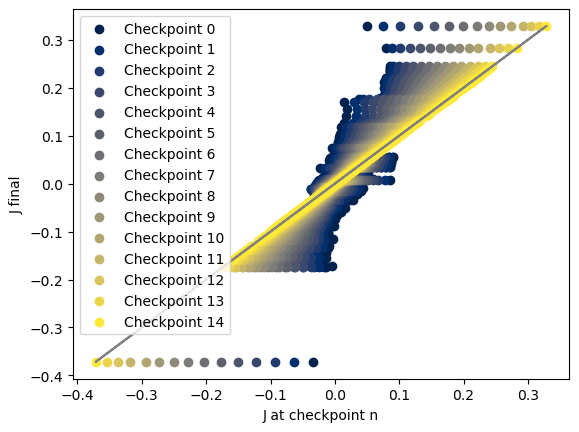

In [68]:
cgrad = [cm.cividis(x) for x in np.linspace(0, 1, len(cps))]
for n in range(len(cps)):
    plt.scatter(utils.off_diagonal_terms(Js[n]), utils.off_diagonal_terms(Js[-1]), 
                label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(Js[-1].reshape(-1), Js[-1].reshape(-1), color='gray')
plt.xlabel('J at checkpoint n')
plt.ylabel('J final')
plt.legend()

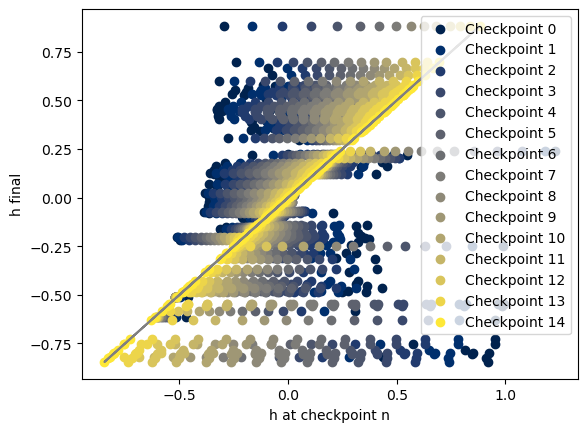

In [69]:
for n in range(len(cps)):
    plt.scatter(hs[n], hs[-1], label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(hs[-1].reshape(-1), hs[-1].reshape(-1), color='gray')
plt.xlabel('h at checkpoint n')
plt.ylabel('h final')
plt.legend()

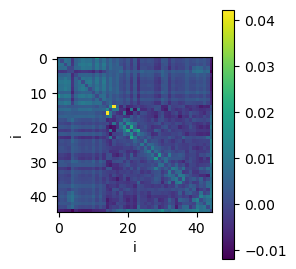

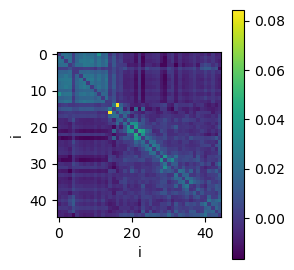

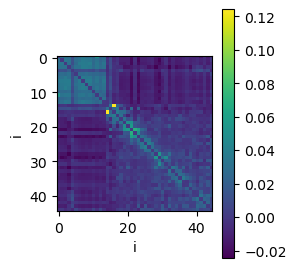

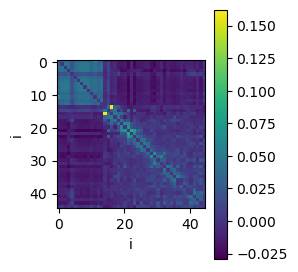

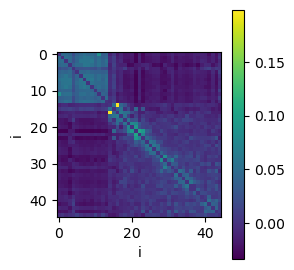

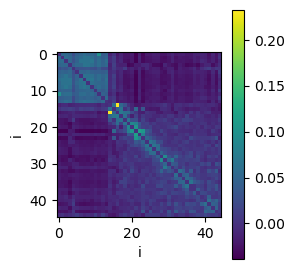

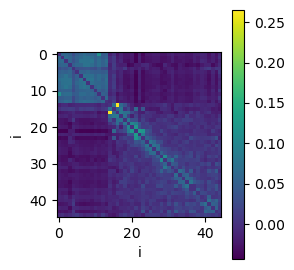

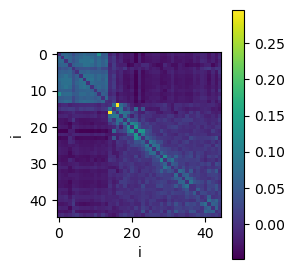

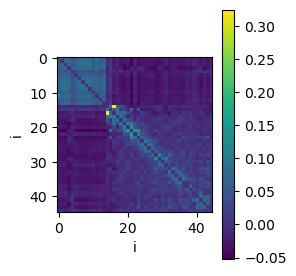

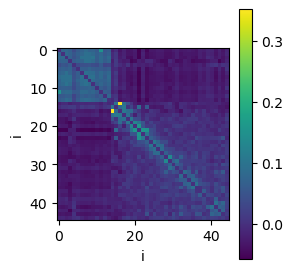

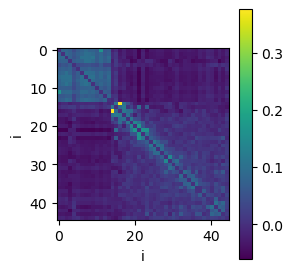

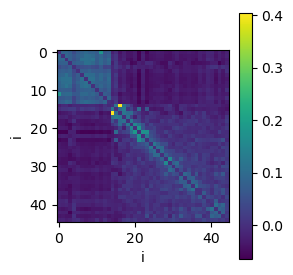

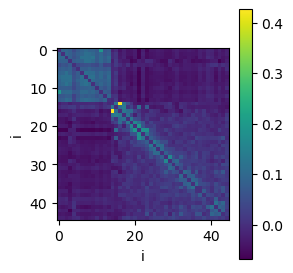

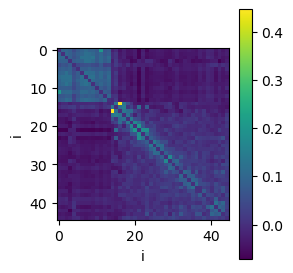

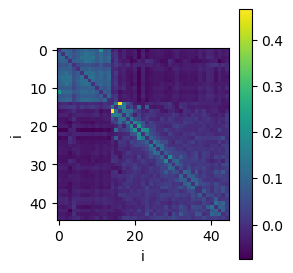

In [70]:
for n in range(len(cps)):
    pl, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(Fs[n])
    ax.set_xlabel("i"); ax.set_ylabel("i")
    plt.colorbar(im)
    plt.tight_layout()